In [20]:
# Importing the libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.svm import SVC
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:

#Importing consolidated data file

raw_data=pd.read_excel(r"C:\Users\SwBatta\Documents\ML Guild contest\Hackathon\Consolidated dataset piece V2.xlsx",sheetname=0)

print("Raw data shape: ",raw_data.shape)

columns_to_include =pd.read_excel(r"C:\Users\SwBatta\Documents\ML Guild contest\Hackathon\New Feature selection.xlsx")

columns_list=columns_to_include[columns_to_include['Selected/not']=="Selected"].Variables.tolist()

print("Number of features selected: ",len(columns_list))

Raw data shape:  (3143, 293)
Number of features selected:  38


In [14]:

#Data manipulation: Convert FIPS to string

raw_data['FIPS']=raw_data['FIPS'].astype(str)
reduced_data = raw_data[columns_list]

#One-hot encoding State variable

categorical = ['State']
data_N = pd.get_dummies(reduced_data, columns = categorical)

# Select only numeric data(drops State)

numerical_features = data_N.select_dtypes(include=[np.number]).columns.tolist()

#Checking for missing values

Missing_values=DataFrame(data_N).isnull().sum().sort_values(ascending=False)
print("Missing_values")
print(Missing_values)

#Imputing missing values with median

for column in numerical_features:
    data_N[column]=data_N[column].fillna(data_N[column].median())

#Checking for missing values

Missing_values_new=DataFrame(data_N).isnull().sum().sort_values(ascending=False)
print("Missing_values after imputation")
print(Missing_values_new)

Missing_values
WIC redemptions/WIC-authorized stores, 2008    1064
WIC redemptions per capita, 2008               1064
Vegetable acres harvested, 2007                 611
Direct farm sales per capita, 2007              288
Direct farm sales, 2007                         288
SNAP benefits per capita, 2010                   83
Vegetable farms, 2007                            63
Farms with direct sales, 2007                    63
Grocery stores (% change), 2009-14               20
Farmers' markets, 2009                            6
Adult obesity rate, 2008                          5
Farm to school program, 2009                      5
Adult diabetes rate, 2008                         5
Population-loss counties, 2010                    2
Persistent-child-poverty counties, 2010           0
% Asian, 2010                                     0
Metro/nonmetro counties, 2010                     0
Per Capita income, 2009                           0
State_AK                                         

In [15]:

#Defining Target variable as the dependent variable

Target=[]
for row in data_N['Grocery stores (% change), 2009-14']:
    if row >=0:
        Target.append(0)
    else:
        Target.append(1)
    
data_N['Target']=Target
data_N['Target'].describe()

dep_var = ["Target"]

y = data_N[dep_var]
   
data_T=data_N[numerical_features]

# Feature Scaling

sc = StandardScaler()
X = sc.fit_transform(data_T)

X_T = DataFrame(X, columns = numerical_features)



In [38]:

#Splitting the data between train and test data sets

X_train, X_test, y_train, y_test = train_test_split(X_T, y, test_size=0.33, random_state=42)

#Observing the correlations between variables

corrmat = X_train.corr()

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [6.0, 4.0]
#print("Current size:",fig_size) 

 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size



#Plotting a heatmap to observe the correlations

#sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

#Observing the correlations of features with target variable

target = y_train.columns.values[0]

features = X_train.columns.tolist()


In [36]:
remove=['Grocery stores (% change), 2009-14']

 
features_N = list(set(features) - set(remove))

correlations = {}
for f in features_N:
    x1 = X_train[f].values
    x2 = y_train[target].values
    key = f + ' vs ' + target
    
    try:
        correlations[key] = pearsonr(x1,x2)[0]
    except:
        print("Div by zero")
            

data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations = data_correlations.loc[data_correlations['Value'].sort_values(ascending=False).index]
print(data_correlations)
X_train_new = X_train[features_N]
X_test_new = X_test[features_N]



                                                       Value
Adult diabetes rate, 2008 vs Target                 0.100993
Adult obesity rate, 2008 vs Target                  0.086908
SNAP benefits per capita, 2010 vs Target            0.078828
State_MI vs Target                                  0.078279
% Black, 2010 vs Target                             0.071644
Vegetable farms, 2007 vs Target                     0.060768
State_PA vs Target                                  0.057159
State_AR vs Target                                  0.057084
State_LA vs Target                                  0.053785
State_TN vs Target                                  0.052682
State_SC vs Target                                  0.050443
State_FL vs Target                                  0.050426
State_AZ vs Target                                  0.049003
State_KY vs Target                                  0.039761
Farms with direct sales, 2007 vs Target             0.035657
State_OH vs Target      

C:\Users\SwBatta\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\SwBatta\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


train set accuracy: 0.6318289786223278
train set sensitivity: 0.4973871733966746
train set specificity: 0.13444180522565322
test set accuracy: 0.5741811175337187
test set sensitivity: 0.4749518304431599
test set specificity: 0.09922928709055877
K fold Accuracy: 0.61 (+/- 0.03)


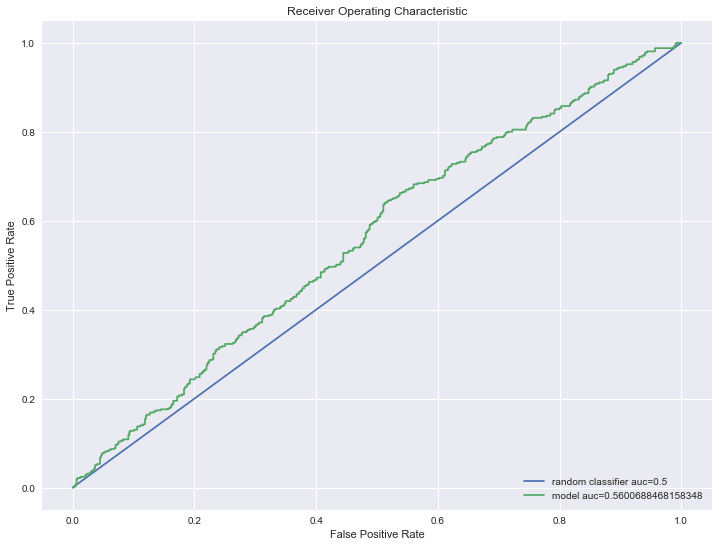

In [39]:
##### Fitting Kernel SVM to the Training set

classifier = SVC(kernel = 'rbf', random_state = 0, probability = True, C=10, gamma=0.001)
classifier.fit(X_train_new, y_train.values.flatten())

# Predicting the Train set results
y_pred_train = classifier.predict(X_train_new)

# Making the Confusion Matrix for training set

cm_train = confusion_matrix(y_train, y_pred_train)
cm_train

train_set_accuracy = (cm_train[0][0]+cm_train[1][1])/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1])
print("train set accuracy:",train_set_accuracy)

sensitivity = cm_train[0][0]/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1])
print("train set sensitivity:",sensitivity)

specificity = cm_train[1][1]/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1])
print("train set specificity:",specificity)

# Predicting the Test set results

y_pred = classifier.predict(X_test_new)

# Making the Confusion Matrix for testing set

cm_test = confusion_matrix(y_test, y_pred)
cm_test

test_set_accuracy = (cm_test[0][0]+cm_test[1][1])/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1])
print("test set accuracy:",test_set_accuracy)

sensitivity = cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1])
print("test set sensitivity:",sensitivity)

specificity = cm_test[1][1]/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1])
print("test set specificity:",specificity)

# Applying k-fold cross validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=classifier, X=X_train_new, y=y_train.values.flatten(), cv =5)
print("K fold Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Applying grid search to find the best model and best parameters
# Found the best params to be c=10, gamma = 0.001, kernel = rbf

#parameters = [{'C':[0.5,1,1.5], 'kernel':['linear']},
#              {'C':[0.2,1,5,10], 'kernel':['rbf'],'gamma':['auto',0.01,0.001,0.0001,0.1,1,2,3]}
#        ]
#grid_search = GridSearchCV(estimator=classifier, param_grid = parameters, scoring = 'accuracy', cv=5)

#grid_search = grid_search.fit(X_train_new, y_train.values.flatten())

#best_accuracy = grid_search.best_score_
#best_parameters  = grid_search.best_params_

#ROC-AUC

from sklearn import metrics

y_pred_proba = classifier.predict_proba(X_test_new)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title('Receiver Operating Characteristic')
plt.plot([0,1],[0,1],label="random classifier auc=0.5")
plt.plot(fpr,tpr,label="model auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

K fold Accuracy: 0.66 (+/- 0.04)
test set accuracy: 0.6339113680154143


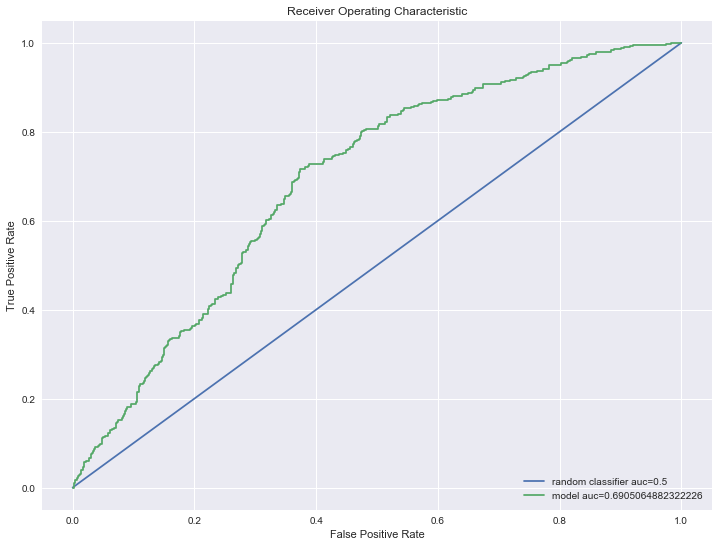

C:\Users\SwBatta\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\SwBatta\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\SwBatta\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

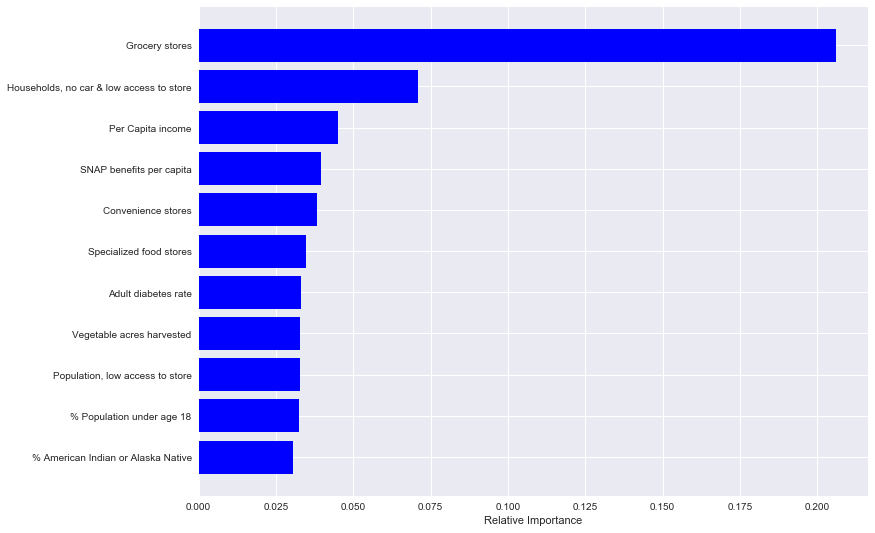

In [40]:
###### Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42, min_samples_leaf=20)
classifier.fit(X_train_new, y_train.values.flatten())

feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = X_train_new.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

new_features = feature_importances[feature_importances.importance>0.03].index.values

X_train_new1 = X_train_new[new_features]
X_test_new1 = X_test_new[new_features]

classifier.fit(X_train_new1, y_train.values.flatten())

#Applying Cross Validation; printing the mean score and the 95% confidence interval of the score estimate
scores = cross_val_score(classifier, X_train_new1, y_train.values.flatten(), cv=5)
print("K fold Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Predicting the Test set results 
y_pred = classifier.predict(X_test_new1)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
test_set_accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("test set accuracy:",test_set_accuracy)

#Applying grid search to find the best model and best parameters
# Found the best params to be c=10, gamma = 0.001, kernel = rbf


#from sklearn.model_selection import GridSearchCV
#parameters = [{'min_samples_leaf':[20,30,50,100,200],'n_estimators':[5,10,15,20,25,30,35,40]}
#        ]
#grid_search = GridSearchCV(estimator=classifier, param_grid = parameters, scoring = 'accuracy', cv=5)

#grid_search = grid_search.fit(X_train_new1, y_train.values.flatten())

#best_accuracy = grid_search.best_score_
#best_parameters  = grid_search.best_params_

#ROC-AUC
y_pred_probab = classifier.predict_proba(X_test_new1)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probab)
auc = metrics.roc_auc_score(y_test, y_pred_probab)
plt.title('Receiver Operating Characteristic')
plt.plot([0,1],[0,1],label="random classifier auc=0.5")
plt.plot(fpr,tpr,label="model auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Feature importance
features_IMP =  feature_importances[feature_importances.importance>0.03]

#Remove year from Feature name
features_IMP['feature']=features_IMP.index.values
features_IMP['feature_new']= features_IMP['feature'].str.strip()
features_IMP['feature_new']=features_IMP['feature_new'].str.split(",")
features_IMP['len']= features_IMP['feature_new'].str.len()-1
for i in features_IMP['len'].astype(int):
    features_IMP['Req feature name']=features_IMP['feature_new'].str[:-i]
features_IMP['New feature name']=""
for i in range(len(features_IMP)):
    features_IMP['New feature name'].iloc[i] = ','.join(features_IMP.iloc[i,4])
 
plt.barh(range(len(features_IMP['importance'])), features_IMP['importance'], color='b', align='center')
plt.yticks(range(len(features_IMP['importance'])), features_IMP['New feature name'])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.show()

#exporting FI

features_IMP.to_csv(r"C:\Users\SwBatta\Documents\ML Guild contest\Hackathon\Feature_importance_RF_SB_2.csv")

#Exporting FIPS and pred probabilities
X_F=X_train_new1.append(X_test_new1)

Y_F=y_train.append(y_test)

# Predicting the Test set results 
y_hats2 = classifier.predict(X_F)

PP = classifier.predict_proba(X_F)[:,1]

X_F['Pred_prob']=PP

Final_file = pd.merge(X_F['Pred_prob'].to_frame(), data_N['FIPS'].to_frame(), left_index=True, right_index=True)



test set accuracy: 0.6541425818882466


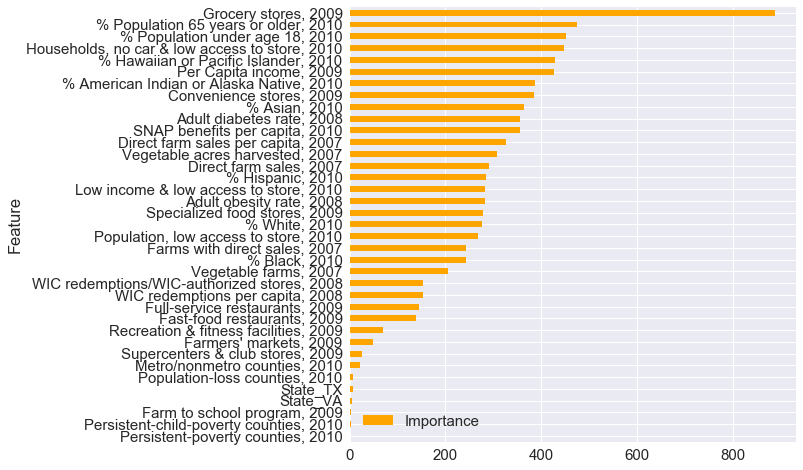

In [44]:
# XGBoost model
import xgboost as xgb
#cv_params = {'n_estimators': [20,50,100,150],'max_depth': [10,15,20,25,30], 'min_child_weight': [5,7,9,11,15,20], 'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'seed':42, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

#Grid Search to find the optimal settings

#optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
#                            cv_params, 
#                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

#optimized_GBM.fit(X_train_new, y_train.values.flatten())
       
#optimized_GBM.grid_scores_       

xgdmat = xgb.DMatrix(X_train_new, y_train.values.flatten()) # Create our DMatrix to make XGBoost more efficient

#Best paramaters from Grid search 

our_params = {'n_estimators': 150, 'seed':42, 'subsample': 0.7, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':25, 'min_child_weight':11, 'eta':0.01} 

# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error
                
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)


# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 40
plt.rcParams["figure.figsize"] = fig_size


import seaborn as sns


importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

testdmat = xgb.DMatrix(X_test_new)

from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

accuracy_score(y_pred, y_test)


# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
test_set_accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("test set accuracy:",test_set_accuracy)

